In [1]:
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
import time
import numpy as np
import imutils
import dlib
import cv2
import face_recognition as fr
import os
from matplotlib import pyplot as plt

In [2]:
db_path = r'/Users/Raikan10/Desktop/FACEDB/' #path to face_db 
known_face_names = list()
file_names = os.listdir(db_path)

for name in file_names:
    if name == db_path + '.DS_Store':
        continue
    known_face_names.append(name.split('.')[0].replace('_',' '))
    #store the names of known people into a list
    
print(known_face_names)

['Lloyd', 'Dutliff', 'Ajay', 'Rahul', 'Dion', 'Shrey', 'Archis', 'Anupam']


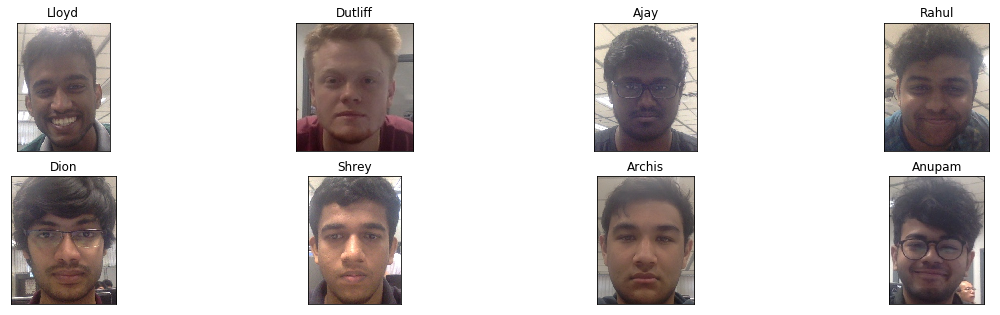

In [3]:
x_inch = 20 #width of the figure in inches
y_inch = 8 #length of the figure in inches
rows = len(file_names)//4+1 #maximum number of rows
cols = 4 #maximum number of columns

#note: rows x cols >= number of images to be plotted

figure1 = plt.figure(figsize=(x_inch,y_inch)) #initialise a figure object to plot the images on


for i, face in enumerate(file_names): 
    
    #can you tell what does the function enumerate() do?
    #hint: try list(enumerate(known_face_names))
    
    file = face
    face_image =  plt.imread( os.path.join( db_path, face) ) #read a single image
    
    ax = figure1.add_subplot(rows, cols, i+1, xticks=[], yticks=[])  
    ax.imshow(face_image) #fill in the image being plotted
    ax.set_title(face.split('.')[0].replace('_',' ')) #fill in the title of the image being plotted
    
plt.show()

In [4]:
known_face_encodings = list()
#compute the face encodings and store them into the list known_face_encoding
for face in file_names:
    person = fr.api.load_image_file(os.path.join(db_path, face))
    face_encoding = fr.api.face_encodings(person)[0]
    known_face_encodings.append(face_encoding)
print('No. of face encodings: %i' %len(known_face_encodings))

No. of face encodings: 8


In [5]:
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [6]:
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 48
COUNTER = 0
TOTAL = 0

In [7]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/Users/Raikan10/Desktop/drowsiness-detection/shape_predictor_68_face_landmarks.dat')

In [ ]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [ ]:
vs = VideoStream(src=0).start()
time.sleep(1.0)
while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=450)
    small_frame = cv2.resize(frame,(0,0),fx=1/4,fy=1/4)
    face_locations = fr.api.face_locations(small_frame,number_of_times_to_upsample=1,model='hog')
    face_encodings = fr.api.face_encodings(small_frame)
    
    for i, face_encoding in enumerate(face_encodings):
            matches = fr.api.compare_faces(known_face_encodings,face_encoding,0.5)#compare face_encoding with known_face_encodings, it will return a list of booleans (match or not)
  
            if True in matches:
                first_match_index = matches.index(True) #Find the index of the first known person being matched
                name =  known_face_names[first_match_index]#Find the matched person's name, 
                #note that we assume the position of known_face_names correspond to the position of known_face_encodings
            else:
                name = "Unknown face"
            
            top, right, bottom, left = face_locations[i]
            top *= 4
            bottom *= 4
            right *= 4
            left *= 4        
            cv2.rectangle(frame,(left,top),(right,bottom),(0,255,0),5,cv2.LINE_AA)
            cv2.putText(frame, name, (left , bottom+30 ), cv2.FONT_HERSHEY_DUPLEX, 1., (0, 255, 0), 3)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        ear = (leftEAR + rightEAR) / 2.0
        if ear < EYE_AR_THRESH:
            COUNTER += 1
        else:
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                TOTAL += 1
                #cv2.putText(frame, "DROWSY", (10, 30),
                    #cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
            COUNTER = 0
            if TOTAL == 0:
                cv2.putText(frame, "FAKE", (200,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "REAL", (200,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
 
    cv2.imshow("A video capture", frame)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
        
cv2.destroyAllWindows()
vs.stop()